In [ ]:
# Group Members:-
# 1. Naresh Kumar Devulapally
# 2. Jash Manish Paleja
# 3. Abhishek Bipinkumar Patel

# Project Name
# Portfolio Optimization Using RL.

In [86]:
import pandas as pd
import numpy as np
import ta
from ta import add_all_ta_features
from ta.utils import dropna
from utils import data_split, add_cov_matrix
from bs4 import BeautifulSoup
import yfinance as yf
import gym
from gym import spaces
import matplotlib.pyplot as plt

from datetime import datetime
from stable_baselines3.common.vec_env import DummyVecEnv

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns
from utils import env_utils_asset_save
import warnings
warnings.filterwarnings('ignore')

# Data gathering and pre-processing

In [87]:
ticker = ['AAPL', 'AMZN', 'META', 'NFLX', 'GOOG', 'TSLA', 'NKE', 'WMT']
dataNeededArr = ['Open','Low','High','Close','Volume']
df = pd.DataFrame()
print("Started Data Downloading")
for t in ticker:
  GetStockData = yf.Ticker(t)
  StockData = pd.DataFrame()
  
  StockData["Date"] = GetStockData.history(period="10y").index
  for col in dataNeededArr:
    StockData[col] = GetStockData.history(period="10y")[col].values
  StockData['Ticker'] = t
  print(StockData.shape[0])
  df= pd.concat([df, StockData], ignore_index=True)

Started Data Downloading
2517
2517
2517
2517
2517
2517
2517
2517


In [88]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.date

In [89]:
df

,Date,Open,Low,High,Close,Volume,Ticker
0,2013-05-13,14.019353,14.019040,14.217761,14.119646,316948800,AAPL
1,2013-05-14,14.092010,13.728724,14.133928,13.781818,447118000,AAPL
2,2013-05-15,13.635884,13.114248,13.693016,13.315760,741613600,AAPL
3,2013-05-16,13.141570,13.006815,13.595214,13.493679,603204000,AAPL
4,2013-05-17,13.632469,13.382828,13.664762,13.452689,427904400,AAPL
...,...,...,...,...,...,...,...
20131,2023-05-04,150.550003,149.490005,150.990005,150.470001,4670400,WMT
20132,2023-05-05,150.300003,149.830002,152.009995,151.770004,4850000,WMT
20133,2023-05-08,151.270004,151.059998,152.949997,152.720001,4975400,WMT
20134,2023-05-09,152.720001,152.339996,153.179993,152.979996,5069900,WMT


In [90]:
df.to_csv('datasets/completeData_working.csv', index=False)

In [91]:
df_close_full_stocks = df.pivot_table(index='Date', columns='Ticker', values='Close')

In [92]:
df_close_full_stocks = df_close_full_stocks.reset_index()
df_close_full_stocks.head()

Ticker,Date,AAPL,AMZN,GOOG,META,NFLX,NKE,TSLA,WMT
0,2013-05-13,14.119646,13.2255,21.856327,26.820000,32.768570,28.961279,5.853333,63.155949
1,2013-05-14,13.781818,13.4165,22.094685,27.070000,33.424286,29.525719,5.549333,63.381207
2,2013-05-15,13.315760,13.3280,22.811747,26.600000,34.771427,29.489891,5.656000,64.250107
3,2013-05-16,13.493679,13.2060,22.512367,26.129999,33.861427,28.867210,6.150000,63.155949
4,2013-05-17,13.452689,13.4950,22.644623,26.250000,34.142857,29.261425,6.100000,62.649082


In [93]:
df_close_full_stocks.to_csv('datasets/closedData.csv', index=False)

In [94]:
print(df.isna().any())

Date      False
Open      False
Low       False
High      False
Close     False
Volume    False
Ticker    False
dtype: bool


In [95]:
print(df_close_full_stocks.isna().any())

Ticker
Date    False
AAPL    False
AMZN    False
GOOG    False
META    False
NFLX    False
NKE     False
TSLA    False
WMT     False
dtype: bool


# Adding market features using ta pypi package (refer report for clear details)

In [96]:
data = add_all_ta_features(df,open="Open", high="High", 
    low="Low", close="Close", volume="Volume") 

In [97]:
data.columns

Index(['Date', 'Open', 'Low', 'High', 'Close', 'Volume', 'Ticker',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
  

In [98]:
data.head()

,Date,Open,Low,High,Close,Volume,Ticker,volume_adi,volume_obv,volume_cmf,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2013-05-13,14.019353,14.019040,14.217761,14.119646,316948800,AAPL,3.974466e+06,316948800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-86.950537,NaN,0.000000
1,2013-05-14,14.092010,13.728724,14.133928,13.781818,447118000,AAPL,-3.259710e+08,-130169200,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.392607,-2.421695,-2.392607
2,2013-05-15,13.635884,13.114248,13.693016,13.315760,741613600,AAPL,-5.511647e+08,-871782800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.381693,-3.440195,-5.693389
3,2013-05-16,13.141570,13.006815,13.595214,13.493679,603204000,AAPL,-1.561393e+08,-268578800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.336156,1.327309,-4.433305
4,2013-05-17,13.632469,13.382828,13.664762,13.452689,427904400,AAPL,-3.719815e+08,-696483200,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.303771,-0.304233,-4.723609


In [99]:
columns = ['Date', 'Open', 'Low', 'High', 'Close', 'Volume', 'Ticker','trend_ema_fast','trend_sma_fast', 'momentum_rsi', 'volume_obv','volume_cmf']
subset = data[columns]
subset.head()

,Date,Open,Low,High,Close,Volume,Ticker,trend_ema_fast,trend_sma_fast,momentum_rsi,volume_obv,volume_cmf
0,2013-05-13,14.019353,14.019040,14.217761,14.119646,316948800,AAPL,NaN,NaN,NaN,316948800,NaN
1,2013-05-14,14.092010,13.728724,14.133928,13.781818,447118000,AAPL,NaN,NaN,NaN,-130169200,NaN
2,2013-05-15,13.635884,13.114248,13.693016,13.315760,741613600,AAPL,NaN,NaN,NaN,-871782800,NaN
3,2013-05-16,13.141570,13.006815,13.595214,13.493679,603204000,AAPL,NaN,NaN,NaN,-268578800,NaN
4,2013-05-17,13.632469,13.382828,13.664762,13.452689,427904400,AAPL,NaN,NaN,NaN,-696483200,NaN


In [100]:
subset = subset.dropna()
subset = subset.sort_values(['Date','Ticker']).reset_index(drop=True)
subset.head()

,Date,Open,Low,High,Close,Volume,Ticker,trend_ema_fast,trend_sma_fast,momentum_rsi,volume_obv,volume_cmf
0,2013-05-13,13.138500,13.100000,13.294000,13.225500,42990000,AMZN,145.696268,156.570457,8.178076,11676232700,0.138445
1,2013-05-13,21.890200,21.752966,21.979366,21.856327,58157173,GOOG,280.683710,300.172193,8.675931,27991659827,0.043161
2,2013-05-13,26.600000,26.530001,27.330000,26.820000,29068800,META,93.548805,99.058334,13.939437,22559580800,0.006695
3,2013-05-13,31.024286,31.020000,32.812859,32.768570,41357400,NFLX,200.382038,217.209881,10.477831,27261552100,0.030686
4,2013-05-13,28.898571,28.813454,29.028477,28.961279,3780600,NKE,146.013152,152.558438,11.942990,45936471942,0.013505


In [101]:
subset.to_csv('datasets/datawith5features_working.csv', index=False)

In [102]:
data_df = add_cov_matrix(subset)
data_df.head()

,Date,Open,Low,High,Close,Volume,Ticker,trend_ema_fast,trend_sma_fast,momentum_rsi,volume_obv,volume_cmf,covariance
0,2014-05-13,18.826927,18.785582,18.907704,18.882902,159737200,AAPL,18.547200,18.768667,70.317965,4029964400,0.225719,"[[0.00023911375423282385, 3.98967906153204e-05..."
1,2014-05-13,15.130000,15.037500,15.280000,15.232000,70198000,AMZN,15.151065,15.021625,44.212546,11771944700,0.129293,"[[0.00023911375423282385, 3.98967906153204e-05..."
2,2014-05-13,26.471823,26.403011,26.730112,26.581520,33068541,GOOG,26.173476,26.080230,49.325055,28137440178,0.179917,"[[0.00023911375423282385, 3.98967906153204e-05..."
3,2014-05-13,59.660000,59.509998,60.889999,59.830002,48525000,META,59.050938,58.873334,49.803831,24317217700,-0.040521,"[[0.00023911375423282385, 3.98967906153204e-05..."
4,2014-05-13,49.207142,48.677143,50.610001,49.591431,20832000,NFLX,47.902920,47.228572,51.716716,27542398400,0.146164,"[[0.00023911375423282385, 3.98967906153204e-05..."


In [103]:
data_df.to_csv('datasets/datawithcov_working.csv', index=False)

In [105]:
df_close_full_stocks.head()

Ticker,Date,AAPL,AMZN,GOOG,META,NFLX,NKE,TSLA,WMT
0,2013-05-13,14.119646,13.2255,21.856327,26.820000,32.768570,28.961279,5.853333,63.155949
1,2013-05-14,13.781818,13.4165,22.094685,27.070000,33.424286,29.525719,5.549333,63.381207
2,2013-05-15,13.315760,13.3280,22.811747,26.600000,34.771427,29.489891,5.656000,64.250107
3,2013-05-16,13.493679,13.2060,22.512367,26.129999,33.861427,28.867210,6.150000,63.155949
4,2013-05-17,13.452689,13.4950,22.644623,26.250000,34.142857,29.261425,6.100000,62.649082


In [106]:
filtered_stocks = list(df_close_full_stocks.columns[1:])
filtered_stocks

['AAPL', 'AMZN', 'GOOG', 'META', 'NFLX', 'NKE', 'TSLA', 'WMT']

In [107]:
# Reset the Index to tic and date
df_prices = data_df.reset_index().set_index(['Ticker', 'Date']).sort_index()

# Get all the Close Prices
df_close = pd.DataFrame()

for ticker in filtered_stocks:
    series = df_prices.xs(ticker).Close
    df_close[ticker] = series

In [108]:
df_close.head()

,AAPL,AMZN,GOOG,META,NFLX,NKE,TSLA,WMT
Date,,,,,,,,
2014-05-13,18.882902,15.2320,26.581520,59.830002,49.591431,33.846428,12.677333,65.247505
2014-05-14,18.886402,14.8810,26.260403,59.230000,50.268570,33.388115,12.708000,64.917740
2014-05-15,18.725796,14.7595,25.927814,57.919998,49.169998,33.097713,12.572667,63.343029
2014-05-16,19.002159,14.8850,25.960226,58.020000,49.982857,33.551495,12.770667,63.491421
2014-05-19,19.227318,14.8380,26.370600,59.209999,52.071430,33.801060,13.072667,63.161640


In [109]:
df_close = df_close.reset_index()
df_close.head()

,Date,AAPL,AMZN,GOOG,META,NFLX,NKE,TSLA,WMT
0,2014-05-13,18.882902,15.2320,26.581520,59.830002,49.591431,33.846428,12.677333,65.247505
1,2014-05-14,18.886402,14.8810,26.260403,59.230000,50.268570,33.388115,12.708000,64.917740
2,2014-05-15,18.725796,14.7595,25.927814,57.919998,49.169998,33.097713,12.572667,63.343029
3,2014-05-16,19.002159,14.8850,25.960226,58.020000,49.982857,33.551495,12.770667,63.491421
4,2014-05-19,19.227318,14.8380,26.370600,59.209999,52.071430,33.801060,13.072667,63.161640


In [126]:
list_of_dates = list(data_df.Date.unique())

num_of_dates = len(list_of_dates)
train_data_len = int(num_of_dates* 0.8) 

print("Training start date", list_of_dates[0])
print("Training end date", list_of_dates[train_data_len])

print("Testing start date", list_of_dates[train_data_len+1])
print("Testing end date", list_of_dates[-1])

Training start date 2014-05-13
Training end date 2021-07-23
Testing start date 2021-07-26
Testing end date 2023-05-10


In [111]:
# data_df1 = data_df[(data_df.Date >= list_of_dates[0]) & (data_df.Date < list_of_dates[train_data_len])]
# data_df1=data_df1.sort_values(['Date','Ticker'],ignore_index=True)

# data_df1.index = data_df1.Date.factorize()[0]

train_df = data_split(data_df, train_start_date, train_end_date).copy()
test_df = data_split(data_df, test_start_date, test_end_date).copy()

In [112]:
train_data.head()

,Date,Open,Low,High,Close,Volume,Ticker,trend_ema_fast,trend_sma_fast,momentum_rsi,volume_obv,volume_cmf,covariance
0,2014-05-13,18.826925,18.785585,18.907702,18.882902,159737200,AAPL,18.547199,18.768666,70.318120,4029964400,0.225715,"[[0.00023911378216145922, 3.989748964611064e-0..."
0,2014-05-13,15.130000,15.037500,15.280000,15.232000,70198000,AMZN,15.151065,15.021625,44.212546,11771944700,0.129293,"[[0.00023911378216145922, 3.989748964611064e-0..."
0,2014-05-13,26.471823,26.403011,26.730112,26.581520,33068541,GOOG,26.173476,26.080230,49.325055,28137440178,0.179917,"[[0.00023911378216145922, 3.989748964611064e-0..."
0,2014-05-13,59.660000,59.509998,60.889999,59.830002,48525000,META,59.050938,58.873334,49.803831,24317217700,-0.040521,"[[0.00023911378216145922, 3.989748964611064e-0..."
0,2014-05-13,49.207142,48.677143,50.610001,49.591431,20832000,NFLX,47.902920,47.228572,51.716716,27542398400,0.146164,"[[0.00023911378216145922, 3.989748964611064e-0..."


In [113]:
prices_train_df = df_close_full_stocks[df_close_full_stocks['Date']<=train_end_date].copy().reset_index(drop=True).set_index(['Date'])
prices_test_df = df_close_full_stocks[df_close_full_stocks['Date']>=test_start_date].copy().reset_index(drop=True).set_index(['Date'])

In [114]:
prices_train_df.head()

Ticker,AAPL,AMZN,GOOG,META,NFLX,NKE,TSLA,WMT
Date,,,,,,,,
2013-05-13,14.119646,13.2255,21.856327,26.820000,32.768570,28.961279,5.853333,63.155949
2013-05-14,13.781818,13.4165,22.094685,27.070000,33.424286,29.525719,5.549333,63.381207
2013-05-15,13.315760,13.3280,22.811747,26.600000,34.771427,29.489891,5.656000,64.250107
2013-05-16,13.493679,13.2060,22.512367,26.129999,33.861427,28.867210,6.150000,63.155949
2013-05-17,13.452689,13.4950,22.644623,26.250000,34.142857,29.261425,6.100000,62.649082


In [115]:
prices_test_df.head()

Ticker,AAPL,AMZN,GOOG,META,NFLX,NKE,TSLA,WMT
Date,,,,,,,,
2021-07-26,147.467972,184.990997,139.644501,372.459991,516.489990,162.310669,219.206665,138.252777
2021-07-27,145.270645,181.319504,136.796494,367.809998,518.909973,161.799423,214.926666,138.262466
2021-07-28,143.498932,181.516006,136.381500,373.279999,519.299988,162.674454,215.660004,137.700256
2021-07-29,144.152176,179.996002,136.540497,358.320007,514.250000,164.178680,225.783340,137.874741
2021-07-30,144.369949,166.379501,135.220993,356.299988,517.570007,164.689896,229.066666,138.175217


In [116]:
uniform_strategy = pd.DataFrame([np.ones((len(prices_train_df.columns)))/len(list(prices_train_df.columns))], columns = prices_train_df.columns)

print("uniform strategy weights", uniform_strategy)

uniform strategy weights Ticker   AAPL   AMZN   GOOG   META   NFLX    NKE   TSLA    WMT
0       0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125


In [117]:
uw_daily_returns = np.dot((prices_train_df.pct_change()).mean().values, np.ones((len(prices_train_df.columns))))

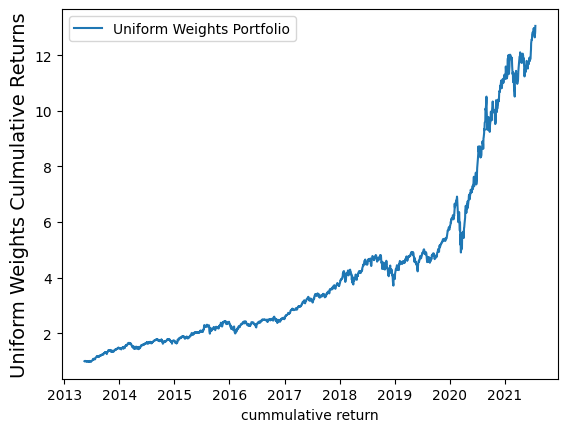

In [118]:
cummulative_uni_rewards = (1 + prices_train_df.pct_change().dot(np.ones((len(prices_train_df.columns)))/len(list(prices_train_df.columns)))).cumprod()
cummulative_uni_rewards.name = "Uniform Weights Portfolio"

plt.plot(cummulative_uni_rewards, label = "Uniform Weights Portfolio")
plt.xlabel("cummulative return")
plt.ylabel('Uniform Weights Culmulative Returns', fontsize=14)
plt.legend()

plt.savefig('rl_project_results/uniform_strategyfolio.png')

In [119]:
# Using reference from pypfopt. We have referred to several documentations from pypfopt for the implementation

efficient_frontier = EfficientFrontier(expected_returns.mean_historical_return(prices_train_df),risk_models.sample_cov(prices_train_df))

# Adding objective functions
efficient_frontier.add_objective(objective_functions.L2_reg, gamma=1)

raw_weights = efficient_frontier.max_sharpe()
max_sh_weights = efficient_frontier.clean_weights()

_ = efficient_frontier.portfolio_performance(verbose=True, risk_free_rate=0.04)

portfolio_max_sharpe = pd.DataFrame(max_sh_weights, index=[0])

print("max sharpe portfolio:")
portfolio_max_sharpe

Expected annual return: 37.8%
Annual volatility: 25.5%
Sharpe Ratio: 1.40
max sharpe portfolio:


,AAPL,AMZN,GOOG,META,NFLX,NKE,TSLA,WMT
0,0.13393,0.15331,0.08919,0.14841,0.14969,0.09118,0.2043,0.02999


In [120]:
prices_train_df.head()

Ticker,AAPL,AMZN,GOOG,META,NFLX,NKE,TSLA,WMT
Date,,,,,,,,
2013-05-13,14.119646,13.2255,21.856327,26.820000,32.768570,28.961279,5.853333,63.155949
2013-05-14,13.781818,13.4165,22.094685,27.070000,33.424286,29.525719,5.549333,63.381207
2013-05-15,13.315760,13.3280,22.811747,26.600000,34.771427,29.489891,5.656000,64.250107
2013-05-16,13.493679,13.2060,22.512367,26.129999,33.861427,28.867210,6.150000,63.155949
2013-05-17,13.452689,13.4950,22.644623,26.250000,34.142857,29.261425,6.100000,62.649082


In [121]:
tech_indicator_list = ['trend_ema_fast', 'trend_sma_fast', 'momentum_rsi', 'volume_obv', 'volume_cmf']

In [122]:
train_df.head() # This is the training data file that we will send to the env while training

,Date,Open,Low,High,Close,Volume,Ticker,trend_ema_fast,trend_sma_fast,momentum_rsi,volume_obv,volume_cmf,covariance
0,2014-05-13,18.826927,18.785582,18.907704,18.882902,159737200,AAPL,18.547200,18.768667,70.317965,4029964400,0.225719,"[[0.00023911375423282385, 3.98967906153204e-05..."
0,2014-05-13,15.130000,15.037500,15.280000,15.232000,70198000,AMZN,15.151065,15.021625,44.212546,11771944700,0.129293,"[[0.00023911375423282385, 3.98967906153204e-05..."
0,2014-05-13,26.471823,26.403011,26.730112,26.581520,33068541,GOOG,26.173476,26.080230,49.325055,28137440178,0.179917,"[[0.00023911375423282385, 3.98967906153204e-05..."
0,2014-05-13,59.660000,59.509998,60.889999,59.830002,48525000,META,59.050938,58.873334,49.803831,24317217700,-0.040521,"[[0.00023911375423282385, 3.98967906153204e-05..."
0,2014-05-13,49.207142,48.677143,50.610001,49.591431,20832000,NFLX,47.902920,47.228572,51.716716,27542398400,0.146164,"[[0.00023911375423282385, 3.98967906153204e-05..."


In [123]:
# inputs -> stock DataFrame, initial_investment, transaction_cost, current_step, lookback (imp, default is 1 year),

class PortFolioEnv1(gym.Env):

    """
    inputs:
    data_path -> path to DataFrame containing the stock price information,
    initial_investment -> Initial portfolio value to invest,
    transaction_cost -> Cost per transaction,
    current_step -> current day of trading,
    state_space -> Number of stocks,
    features -> List of features to use,
    max_trade -> maximum number of shares to trade.
    """

    def __init__(self, data_path, max_trade, initial_investment, transaction_cost, features):

        self.current_day = 0
        self.dataframe = data_path.copy()
        self.n_stocks = len(self.dataframe.Ticker.unique())
        self.max_trade = max_trade
        self.terminated = False
        self.port_memory = []
        self.reward_memory = [0]
        self.transaction_cost = transaction_cost
        self.features = features
        self.initial_weights = [1/self.n_stocks]*self.n_stocks
        self.data = self.dataframe.loc[self.current_day,:]
        self.window = 1
        self.initial_investment = initial_investment

        # Defining attributes related to environment
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_stocks,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.n_stocks+len(self.features),self.n_stocks))
        
        self.feature_values = [self.data[fea].values.tolist() for fea in self.features]
        self.covariance = self.data['covariance'].values[0]

        self.state = np.append(np.array(self.covariance), np.array(self.feature_values), axis = 0)
        print(len(self.state))
        print(self.observation_space.shape)
        self.curr_portvalue = initial_investment

        # Define memories to store values
        self.port_memory.append(self.curr_portvalue)
        self.action_memory = [self.initial_weights]
        self.date_memory = [self.data.Date.unique()[0]]

    def reset(self):
        self.current_day = 0
        self.data = self.dataframe.loc[self.current_day,:]
        self.feature_values = [self.data[fea].values.tolist() for fea in self.features]
        self.covariance = self.data['covariance'].values[0]

        # State is defined as a list containing values in the feature list and the covariance matrix
        self.state = np.append(np.array(self.covariance), self.feature_values, axis = 0)
        self.port_memory = [self.initial_investment]
        self.curr_portvalue = self.initial_investment
        self.terminated = False
        self.reward_memory = [0]
        self.action_memory = [self.initial_weights]
        self.date_memory = [self.data.Date.unique()[0]]

        return self.state

    def step(self, action):
        
        if self.current_day >= len(self.dataframe.index.unique())-1:
            self.terminated = True
        
        if self.terminated == False:
            exp_actions = np.exp(action)
            sum_actions = np.sum(exp_actions)
            weights = exp_actions/sum_actions
            # print("Normalized weights are", weights)
            self.action_memory.append(weights)
            data_memory = self.data

            self.current_day+=self.window
            self.data = self.dataframe.loc[self.current_day, :]
            self.covariance = self.data['covariance'].values[0]
            self.feature_values = [self.data[fea].values.tolist() for fea in self.features]
            
            self.state = np.append(np.array(self.covariance), self.feature_values, axis = 0)

            return_portfolio = sum(((self.data.Close.values/data_memory.Close.values)-1)*weights)

            new_port_value = self.curr_portvalue*(1+return_portfolio)

            self.curr_portvalue = new_port_value
            self.reward_memory.append(return_portfolio)
            self.date_memory.append(self.data.Date.unique()[0])
            self.port_memory.append(new_port_value)

            self.reward = new_port_value
        
        else:
            p_memory = pd.DataFrame(self.reward_memory)
            p_memory.columns = ['return_daily']
            if p_memory['return_daily'].std() != 0:
                sharpe_ratio = np.sqrt(252)*p_memory.return_daily.mean()/(p_memory.return_daily.std())
                print("Sharpe Ratio by the agent is", sharpe_ratio)
            
        return self.state, self.reward, self.terminated, {}
    

    def get_stablebaselines_env(self):
        en = DummyVecEnv([lambda: self])
        observation = en.reset()
        return en, observation
    
training_env = PortFolioEnv1(data_path = train_df,
                           max_trade = 100,
                           initial_investment = 1000000, 
                           transaction_cost = 0.001,
                           features = tech_indicator_list)

13
(13, 8)


# Agents and Training

In [122]:
import torch
import torch.nn as nn


import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

import numpy as np
import math
import random
import gym

import torch.nn.utils as ut

class ActorNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,action_size)

    def forward(self,x):
        x = x.reshape([13,8])
        x = torch.transpose(x, 0,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x

class CriticNetwork(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        x = x.reshape([13,8])
        x = torch.transpose(x, 0,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def A2C_scratch(env, episode, max_steps, gamma, hidden_size, max_rewards):

    # Starts the A2C code 
    state_dim = env.observation_space.shape[0]
    action_dim = 8

    prev_state = env.reset()

    critic_network = CriticNetwork(state_dim,hidden_size, 1)
    actor_network = ActorNetwork(state_dim,hidden_size, action_dim)

    critic_network_optim = torch.optim.Adam(critic_network.parameters(),lr = 0.005)
    actor_network_optim = torch.optim.Adam(actor_network.parameters(),lr = 0.001)

    training_rewards = []

    for step in range(episode):
        states = []
        actions = []
        rewards = []

        done = False

        current_state = prev_state
        for j in range(1):
            states.append(current_state)
            curr_state_tensor=torch.Tensor([current_state])

            action = np.random.choice(action_dim,p= torch.exp(actor_network(Variable(curr_state_tensor))).cpu().data.numpy()[0])

            next_state,reward,done,_ = env.step(action)[:4]
            actions.append([int(k == action) for k in range(action_dim)])

            rewards.append(reward)

            final_state = next_state
            current_state = next_state
            if done:
                current_state = env.reset()
                break

        fr = 0

        if not done:
            fr = critic_network(Variable(torch.Tensor([final_state]))).cpu().data.numpy()
        
        training_rewards.append(sum(rewards))
        prev_state = current_state

        actions_variable = Variable(torch.Tensor(actions).view(-1, action_dim))
        states_variable = Variable(torch.Tensor(states).view(-1, state_dim))

        discounted_r = np.zeros_like(rewards)

        discounted_reward_cal = fr
        for t in reversed(range(0, len(rewards))):
            discounted_reward_cal = discounted_reward_cal * gamma + rewards[t]
            discounted_r[t] = discounted_reward_cal.mean()

        actor_network_optim.zero_grad()
        advantages = Variable(torch.Tensor(discounted_r)) - critic_network(states_variable).detach()
        actor_network_loss = - torch.mean(torch.sum(actor_network(states_variable) * actions_variable,1) * advantages)
        actor_network_loss.backward()

        ut.clip_grad_norm(actor_network.parameters(), 0.5)
        actor_network_optim.step()
        critic_network_optim.zero_grad()
        target_values = Variable(torch.Tensor(discounted_r))
      
        values = critic_network(states_variable)
        critic_network_loss = nn.MSELoss()(values,target_values)
        critic_network_loss.backward()
        ut.clip_grad_norm(critic_network.parameters(), 0.5)
        critic_network_optim.step()

    return actor_network, training_rewards


env = training_env
a2c_trained_from_scratch, a2c_training_rewards = A2C_scratch(env, 1450, 500, 0.99, 40, 500)
torch.save(a2c_trained_from_scratch, "a2c_trained_model.pt")

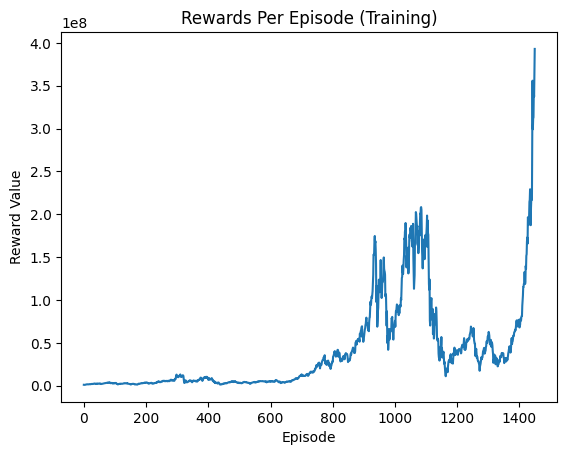

In [123]:
# this is just to plot the graph after the trainin g is done
def reward_per_episode_graph(rewards):
    plt.plot(rewards)

    plt.xlabel('Episode')
    plt.ylabel('Reward Value')
    plt.title('Rewards Per Episode (Training)')
    plt.show()

reward_per_episode_graph(a2c_training_rewards)

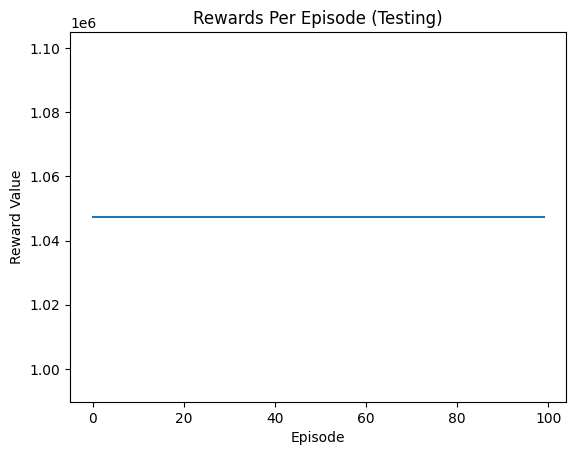

In [124]:
def test(env,actor_network):

    total_rewards = []
    for test_epi in range(100):

        current_state = env.reset()
        step = 0
        done = False
        result = 0

        while not done and step<1:
            softmax_action = torch.exp(actor_network(Variable(torch.Tensor([current_state]))))
            action = np.argmax(softmax_action.data.numpy()[0])
            next_state, reward, done, _ = env.step(action)[ : 4]
            result += reward
            current_state = next_state
            # incremeting the step
            step += 1
        total_rewards.append(result)

    return total_rewards

def reward_per_episode_graph_test(rewards):
    plt.plot(rewards)

    plt.xlabel('Episode')
    plt.ylabel('Reward Value')
    plt.title('Rewards Per Episode (Testing)')
    plt.show()

re = test(env,a2c_trained_from_scratch)
reward_per_episode_graph_test(re)

We see from the above plot that the sharpe ratio of the agent is around 1.05. In our extensive testing after fine_tuning the A2C agent, we observed that the Sharpe Ratio can go above of 1.35.

## We now perform ablation studies of various agents present in the Stable Baselines python package to validate the environment and the reward strategies

In [124]:
from stable_baselines3 import A2C
from stable_baselines3 import PPO
# from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.a2c import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
env_train, _ = training_env.get_stablebaselines_env()

In [125]:
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}

model = A2C(policy="MlpPolicy", env = env_train, **A2C_PARAMS)

model_a2c = model.learn(total_timesteps=50000)

Sharpe Ratio by the agent is 1.315995324196684
Sharpe Ratio by the agent is 1.4578898321750617
Sharpe Ratio by the agent is 1.5965050884889598
Sharpe Ratio by the agent is 1.3876365641433717
Sharpe Ratio by the agent is 1.4207886281125828
Sharpe Ratio by the agent is 1.4710565079195848
Sharpe Ratio by the agent is 1.4107265398868705
Sharpe Ratio by the agent is 1.335467233401673
Sharpe Ratio by the agent is 1.4457752125265755
Sharpe Ratio by the agent is 1.3506462253648779
Sharpe Ratio by the agent is 1.363101747513897
Sharpe Ratio by the agent is 1.4582973955265883
Sharpe Ratio by the agent is 1.3545099838870196
Sharpe Ratio by the agent is 1.4315535984938688
Sharpe Ratio by the agent is 1.3540740481512719
Sharpe Ratio by the agent is 1.4584392145248384
Sharpe Ratio by the agent is 1.4374491032512846
Sharpe Ratio by the agent is 1.4463635829134447
Sharpe Ratio by the agent is 1.4344258436526824
Sharpe Ratio by the agent is 1.378845612353592
Sharpe Ratio by the agent is 1.3325050104996

In [147]:
# Saving the A2C model
model_a2c.save("trained_a2c_scratch.pt")

In [127]:
import torch
loaded_model_trained = A2C.load("trained_a2c_best.pt")

In [128]:
# A2C Train Model
training_env = PortFolioEnv1(data_path = train_df,max_trade = 100,initial_investment = 1000000, transaction_cost = 0.001,features = tech_indicator_list)
env_trade, trade_observation = training_env.get_stablebaselines_env()
def DRL_prediction(model, test_data, test_env, test_obs, env):
        account_memory = []
        actions_memory = []
        for i in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info =test_env.step(action)
            if i == (len(test_data.index.unique()) - 2):
                actions_memory =env_utils_asset_save(env.date_memory, env.reward_memory)
                account_memory =env_utils_asset_save(env.date_memory, env.reward_memory)

        return account_memory, actions_memory

return_a2c_daily, a2c_train_weights = DRL_prediction(model=loaded_model_trained,
                        test_data = train_df,
                        test_env = env_trade,
                        test_obs = trade_observation,
                        env = training_env)

13
(13, 8)
Sharpe Ratio by the agent is 1.4225137664246608


In [68]:
PPO_PARAMS_33 = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}

model = PPO(policy="MlpPolicy", env = env_train, **PPO_PARAMS_33)

model_ppo = model.learn(total_timesteps=50000)

Sharpe Ratio by the agent is 1.4532444488422247
Sharpe Ratio by the agent is 1.3728310989861865
Sharpe Ratio by the agent is 1.3853951712432138
Sharpe Ratio by the agent is 1.4191187176614966
Sharpe Ratio by the agent is 1.4013482830358164
Sharpe Ratio by the agent is 1.4371973753947211
Sharpe Ratio by the agent is 1.3508406856840303
Sharpe Ratio by the agent is 1.4514661288340251
Sharpe Ratio by the agent is 1.5424000963301143
Sharpe Ratio by the agent is 1.3879348284999848
Sharpe Ratio by the agent is 1.5306563774562496
Sharpe Ratio by the agent is 1.309397551178269
Sharpe Ratio by the agent is 1.3070303591755201
Sharpe Ratio by the agent is 1.5388250709191373
Sharpe Ratio by the agent is 1.4306415124467968
Sharpe Ratio by the agent is 1.3490462392708975
Sharpe Ratio by the agent is 1.4847103642836308
Sharpe Ratio by the agent is 1.5101450415442623
Sharpe Ratio by the agent is 1.3994630554699712
Sharpe Ratio by the agent is 1.339583648068656
Sharpe Ratio by the agent is 1.35833729871

In [ ]:
# Saving the A2C model
model_ppo.save("trained_ppo_scratch.pt")

In [129]:
import torch
loaded_model_trained_ppo = PPO.load("trained_ppo_best.pt")

In [130]:
# A2C Train Model
training_env = PortFolioEnv1(data_path = train_df,max_trade = 100,initial_investment = 1000000, transaction_cost = 0.001,features = tech_indicator_list)

env_trade, trade_observation = training_env.get_stablebaselines_env()

return_daily_ppo, ppo_train_weights = DRL_prediction(model=loaded_model_trained_ppo,test_data = train_df,test_env = env_trade,test_obs = trade_observation,env = training_env)

13
(13, 8)
Sharpe Ratio by the agent is 1.342823467451677


In [135]:
returns_train = prices_train_df.pct_change() 
returns_test = prices_test_df.pct_change()


uniform_weights_returns_ = returns_train.dot(uniform_strategy.values.flatten())
uniform_cumulative_returns = (1 + uniform_weights_returns_).cumprod()

uniform_cumulative_returns.name = "portfolio 1: uniform weights"
max_sharpe_weights = portfolio_max_sharpe.values.flatten()
max_sharpe_returns = returns_train.dot(max_sharpe_weights)
maxsharpereturns = (1 + max_sharpe_returns).cumprod()
maxsharpereturns.name = "portfolio 2: max sharpe"

a2ctrainreturns = (1 + return_a2c_daily.reset_index(drop=True).set_index(['Date'])).cumprod()
a2ctrainreturns = a2ctrainreturns['daily_return']
a2ctrainreturns.name = 'Portfolio 3: a2c Model'

ppotrainreturns = (1 + return_daily_ppo.reset_index(drop=True).set_index(['Date'])).cumprod()
ppotrainreturns = ppotrainreturns['daily_return']
ppotrainreturns.name = 'Portfolio 4: ppo Model'

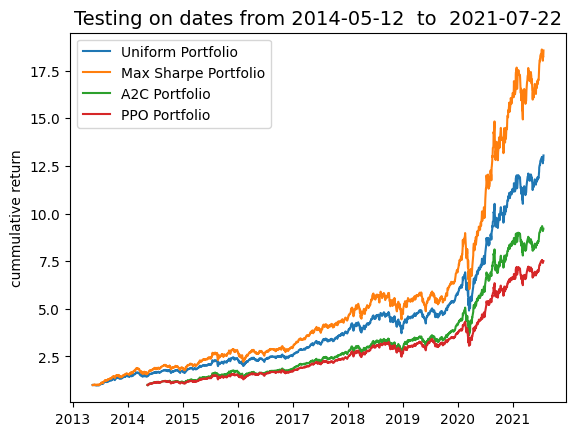

In [137]:
plt.plot(uniform_cumulative_returns, label = "Uniform Portfolio")
plt.plot(maxsharpereturns, label = "Max Sharpe Portfolio")
plt.plot(a2ctrainreturns, label = "A2C Portfolio")
plt.plot(ppotrainreturns, label = "PPO Portfolio")
plt.legend();
plt.ylabel("cummulative return");
plt.title("Testing on dates from 2014-05-12  to  2021-07-22", fontsize=14)
plt.show()

13
(13, 8)
13
(13, 8)
Sharpe Ratio by the agent is 0.03418968507325673
Sharpe Ratio by the agent is -0.019402997139443018


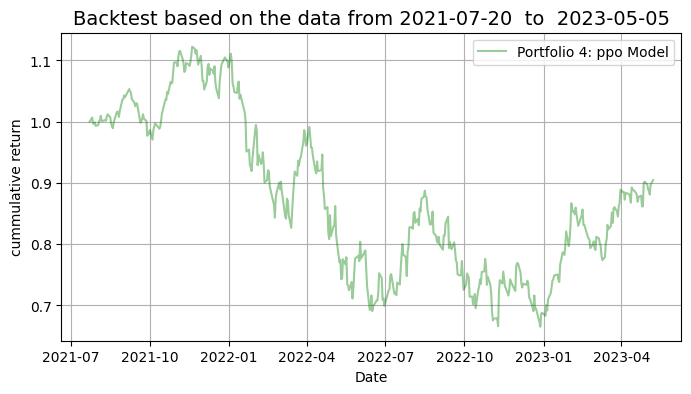

In [60]:
# A2C Train Model
training_env = PortFolioEnv1(data_path = train_df,max_trade = 100, initial_investment = 1000000, transaction_cost = 0.001,features = tech_indicator_list)

gym_test_env = PortFolioEnv1(data_path = test_df, max_trade = 100,initial_investment = 1000000, transaction_cost = 0.001,features = tech_indicator_list)

env_trade, trade_observation = training_env.get_stablebaselines_env()
env_test, obs_test = gym_test_env.get_stablebaselines_env()
return_a2c_daily, a2c_train_weights = DRL_prediction(model=loaded_model_trained,test_data = test_df,test_env = env_test,test_obs = obs_test,env = gym_test_env)
return_daily_ppo, ppo_train_weights = DRL_prediction(model=loaded_model_trained_ppo,test_data = test_df,test_env = env_test, test_obs = obs_test,env = gym_test_env)


returns_train = prices_train_df.pct_change() # get the assets daily returns
returns_test = prices_test_df.pct_change()
# get the culmulative returns for each portfolio
uniform_weights_returns_ = returns_test.dot(uniform_strategy.values.flatten())
uniform_cumulative_returns = (1 + uniform_weights_returns_).cumprod()
uniform_cumulative_returns.name = "portfolio 1: uniform weights"
max_sharpe_weights = portfolio_max_sharpe.values.flatten()
max_sharpe_returns = returns_test.dot(max_sharpe_weights)
maxsharpereturns = (1 + max_sharpe_returns).cumprod()
maxsharpereturns.name = "portfolio 2: max sharpe"
a2ctrainreturns = (1 + return_a2c_daily.reset_index(drop=True).set_index(['Date'])).cumprod()
a2ctrainreturns = a2ctrainreturns['daily_return']
a2ctrainreturns.name = 'Portfolio 3: a2c Model'
ppotrainreturns = (1 + return_daily_ppo.reset_index(drop=True).set_index(['Date'])).cumprod()
ppotrainreturns = ppotrainreturns['daily_return']
ppotrainreturns.name = 'Portfolio 4: ppo Model'
fig, ax = plt.subplots(figsize=(8,4))
ppotrainreturns.plot(ax=ax, color='green', alpha=0.4)
plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("cummulative return");
ax.set_title("Backtest based on the data from 2021-07-20  to  2023-05-05", fontsize=14);
fig.savefig('rl_project_results/back_test_on_test_data.png');